# 1. Importing Libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import random
import torchvision

from typing import List, Dict, Tuple
from torch import nn
from torchvision.transforms import transforms
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from helper_functions import create_dataloaders, set_seeds, display_random_images, plot_loss_curves, save_model, load_model
from engine import train, create_writer
from vision_transformer import ViT

# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_model': True,
    'save_model':  True,    
}

# Define target data directory
target_dir_name = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"
target_dir.mkdir(parents=True, exist_ok=True)

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Image size
IMG_SIZE = 224

# Manual transforms for the training dataset
manual_transforms = v2.Compose([           
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),    
])

# Manual transforms for the training dataset
manual_transforms_aug_norm_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((256, 256)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test = v2.Compose([    
    v2.Resize((256, 256)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

pretrained_vit_transforms = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

In [4]:
print(f"Pretrained create transforms: {pretrained_vit_transforms}")
#print(f"Manually create transforms: {manual_transforms_aug_norm_train}")

Pretrained create transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
# Create data loaders
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# train_dataloader_vit, test_dataloader_vit, class_names

# 3. Image Visualization

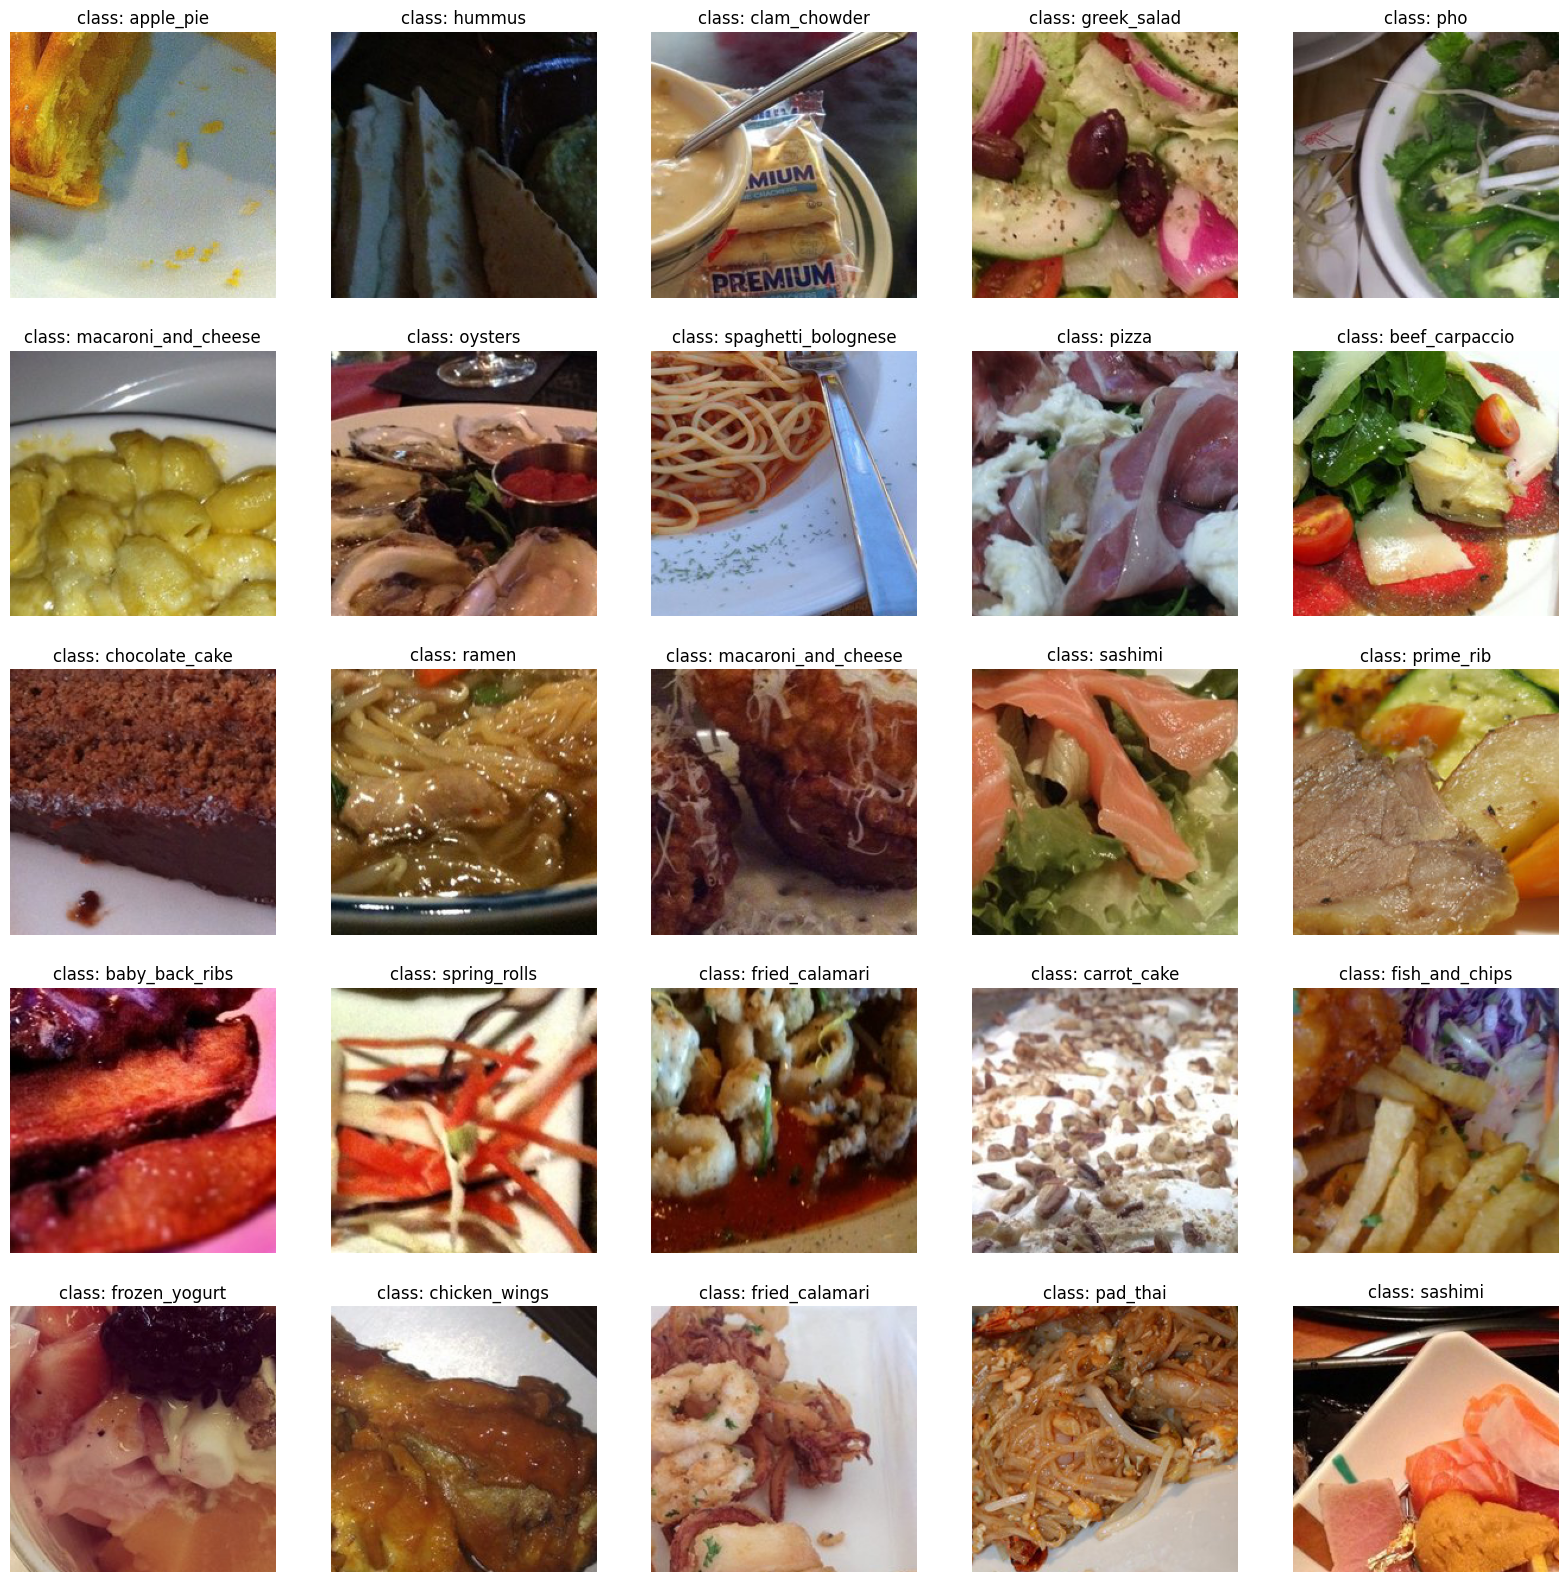

In [6]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 4. Vision Transformer (ViT) - Base

This section outlines the creation, compilation, and training of multiple ViT-Base networks using transfer learning. Transfer learning allows leveraging pre-trained models to achieve high accuracy with reasonable training times by fine-tuning for the specific task at hand, in this case for food recognition.

| Version | **ViT Type** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 30 | None | 85.9M |
| 2 | Base | 16x16 | 12 | 768 | 3072 | 12 | None | Yes | 30 | CosineAnnealingLR | 85.9M |
| 3 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 30 | None | 86.7M |
| 4 | Base | 16x16 | 12 | 768 | 3072 | 12 | 1024 | Yes | 50 | None | 86.7M |
| 5 | Large | 16x16 | 24 | 1024 | 4096 | 16 | None | Yes | 50 | None | 303.4M

## 4.1 Version 1

In [7]:
# Set the pretrained weights of ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

In [ ]:
# Create a ViT-Base Model
vitbase16_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

In [8]:
# Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
vitbase16_model.copy_weights(pretrained_vit_weights)

# And freeze the backbone except the classification head params
vitbase16_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitbase16_model)

# Print sumary
summary(vitbase16_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 224, 224]    [64, 101]            --                   Partial
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              False
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
│    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
├─Sequential (encoder)                                       [64, 197, 768]       [64, 197, 768]       --                   False
│    └─TransformerEncoderBlock (0)                           [64, 197, 768]       [64, 197

In [9]:
summary(pretrained_vit,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]    [64, 101]            768                  True
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [64, 197, 768]       [64, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential (layers)                                   [64, 197, 768]       [64, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 768]       [64, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 768]       [64, 197, 76

In [10]:
# Check out that the parameters have been sucessfully copied
print("Weights of the pretrained model")
for name, param in pretrained_vit.named_parameters():
    print(f"{name}: {param.data.mean()}")

print("...................")
print("Weights of the ViTBase model")
for name, param in vitbase16_model.named_parameters():
    print(f"{name}: {param.data.mean()}")

Weights of the pretrained model
class_token: 1.7750737242749892e-05
conv_proj.weight: 1.7673688489594497e-05
conv_proj.bias: 0.0016533341258764267
encoder.pos_embedding: 0.00018699619977269322
encoder.layers.encoder_layer_0.ln_1.weight: 0.029956921935081482
encoder.layers.encoder_layer_0.ln_1.bias: -2.9846512916265056e-05
encoder.layers.encoder_layer_0.self_attention.in_proj_weight: 8.55640391819179e-05
encoder.layers.encoder_layer_0.self_attention.in_proj_bias: -0.0003499813610687852
encoder.layers.encoder_layer_0.self_attention.out_proj.weight: 8.699058184902242e-07
encoder.layers.encoder_layer_0.self_attention.out_proj.bias: 0.0015855792444199324
encoder.layers.encoder_layer_0.ln_2.weight: 0.14148560166358948
encoder.layers.encoder_layer_0.ln_2.bias: 0.00022927715326659381
encoder.layers.encoder_layer_0.mlp.0.weight: -4.523561801761389e-05
encoder.layers.encoder_layer_0.mlp.0.bias: -0.0014407830312848091
encoder.layers.encoder_layer_0.mlp.3.weight: 1.064492516889004e-05
encoder.laye

The sizes of both models coincide and the copy operation looks correct.

Epoch: 30 | train_loss: 2.3482 | train_acc: 0.5672 | test_loss: 1.7447 | test_acc: 0.7382 | lr: 0.0001000000 


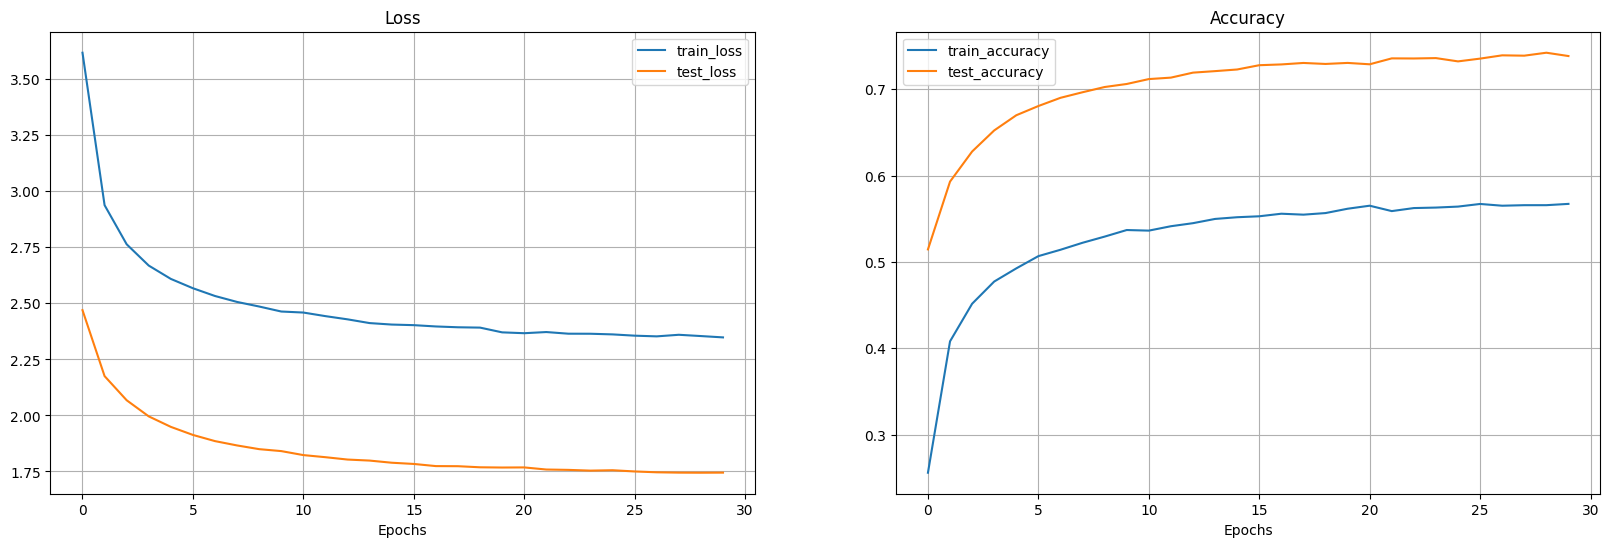

In [ ]:
# Training
model_type="vitbase16"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitbase16_model_name = model_name + ".pth"
vitbase16_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vitbase16_model_name}")
print(f"Results path: {vitbase16_results_df}")

# Train the model
if ENABLE['train_model']:

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase16_results = train(model=vitbase16_model, 
                            train_dataloader=train_dataloader_vit,
                            test_dataloader=test_dataloader_vit,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            writer=None)

In [ ]:
# Save the ViT Base model
if ENABLE['save_model']:
   save_model(model=vitbase16_model,
              target_dir=model_dir,
              model_name=vitbase16_model_name)
   df_results = pd.DataFrame(vitbase16_results)
   df_results.to_csv(os.path.join(model_dir, vitbase16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_lr000100_30epochs.pth


## 4.2 Version 2

In [ ]:
# Create a ViT-Base Model
vitbase16_2_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
vitbase16_2_model.copy_weights(pretrained_vit_weights)

# And freeze the backbone except the classification head params
vitbase16_2_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitbase16_2_model)

# Print sumary
summary(vitbase16_2_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 224, 224]    [64, 101]            --                   Partial
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              False
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
│    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
├─Sequential (encoder)                                       [64, 197, 768]       [64, 197, 768]       --                   False
│    └─TransformerEncoderBlock (0)                           [64, 197, 768]       [64, 197

Epoch: 30 | train_loss: 2.4031 | train_acc: 0.5526 | test_loss: 1.7870 | test_acc: 0.7216 | lr: 0.0000905463 


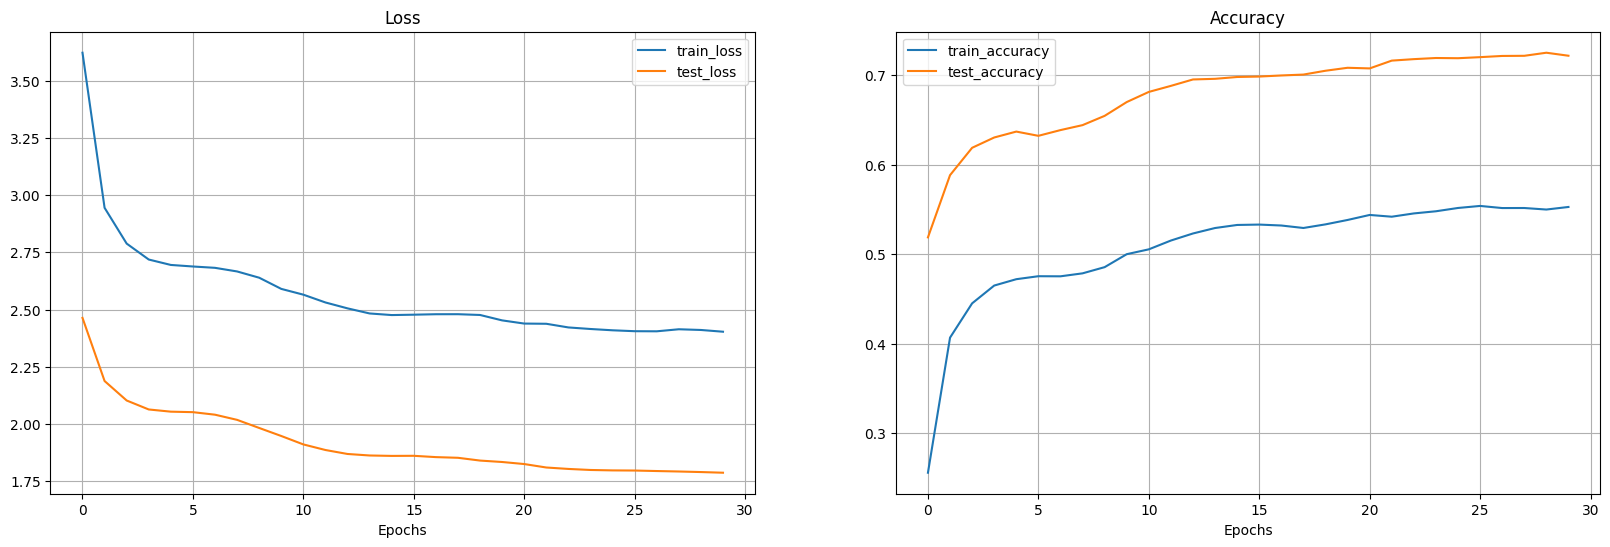

In [ ]:
model_type="vitbase16_v2"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitbase16_2_model_name = model_name + ".pth"
vitbase16_2_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vitbase16_2_model_name}")
print(f"Results path: {vitbase16_2_results_df}")

# Train the model
if ENABLE['train_model']:

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_2_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase16_2_results = train(model=vitbase16_2_model, 
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=scheduler,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                writer=None)

In [15]:
# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitbase16_2_model,
              target_dir=model_dir,
              model_name=vitbase16_2_model_name)
   df_results = pd.DataFrame(vitbase16_2_results)
   df_results.to_csv(os.path.join(model_dir, vitbase16_2_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_v2_lr000100_30epochs.pth


## 4.3 Version 3

In [11]:
# Create a ViT-Base Model
vitbase16_3_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    classif_head_hidden_units=1024,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
vitbase16_3_model.copy_weights(pretrained_vit_weights)

# And freeze the backbone except the classification head params
vitbase16_3_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitbase16_3_model)

# Print sumary
summary(vitbase16_3_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 224, 224]    [64, 101]            --                   Partial
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              False
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
│    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
├─Sequential (encoder)                                       [64, 197, 768]       [64, 197, 768]       --                   False
│    └─TransformerEncoderBlock (0)                           [64, 197, 768]       [64, 197

In [12]:
# Check out that the parameters have been sucessfully copied
print("Weights of the pretrained model")
for name, param in pretrained_vit.named_parameters():
    print(f"{name}: {param.data.mean()}")

print("...................")
print("Weights of the ViTBase model")
for name, param in vitbase16_3_model.named_parameters():
    print(f"{name}: {param.data.mean()}")

Weights of the pretrained model
class_token: 1.7750737242749892e-05
conv_proj.weight: 1.7673688489594497e-05
conv_proj.bias: 0.0016533341258764267
encoder.pos_embedding: 0.00018699619977269322
encoder.layers.encoder_layer_0.ln_1.weight: 0.029956921935081482
encoder.layers.encoder_layer_0.ln_1.bias: -2.9846512916265056e-05
encoder.layers.encoder_layer_0.self_attention.in_proj_weight: 8.55640391819179e-05
encoder.layers.encoder_layer_0.self_attention.in_proj_bias: -0.0003499813610687852
encoder.layers.encoder_layer_0.self_attention.out_proj.weight: 8.699058184902242e-07
encoder.layers.encoder_layer_0.self_attention.out_proj.bias: 0.0015855792444199324
encoder.layers.encoder_layer_0.ln_2.weight: 0.14148560166358948
encoder.layers.encoder_layer_0.ln_2.bias: 0.00022927715326659381
encoder.layers.encoder_layer_0.mlp.0.weight: -4.523561801761389e-05
encoder.layers.encoder_layer_0.mlp.0.bias: -0.0014407830312848091
encoder.layers.encoder_layer_0.mlp.3.weight: 1.064492516889004e-05
encoder.laye

Epoch: 30 | train_loss: 2.1458 | train_acc: 0.6141 | train_time: 5m29s | test_loss: 1.6577 | test_acc: 0.7550 | test_time: 2m2s | lr: 0.0001000000


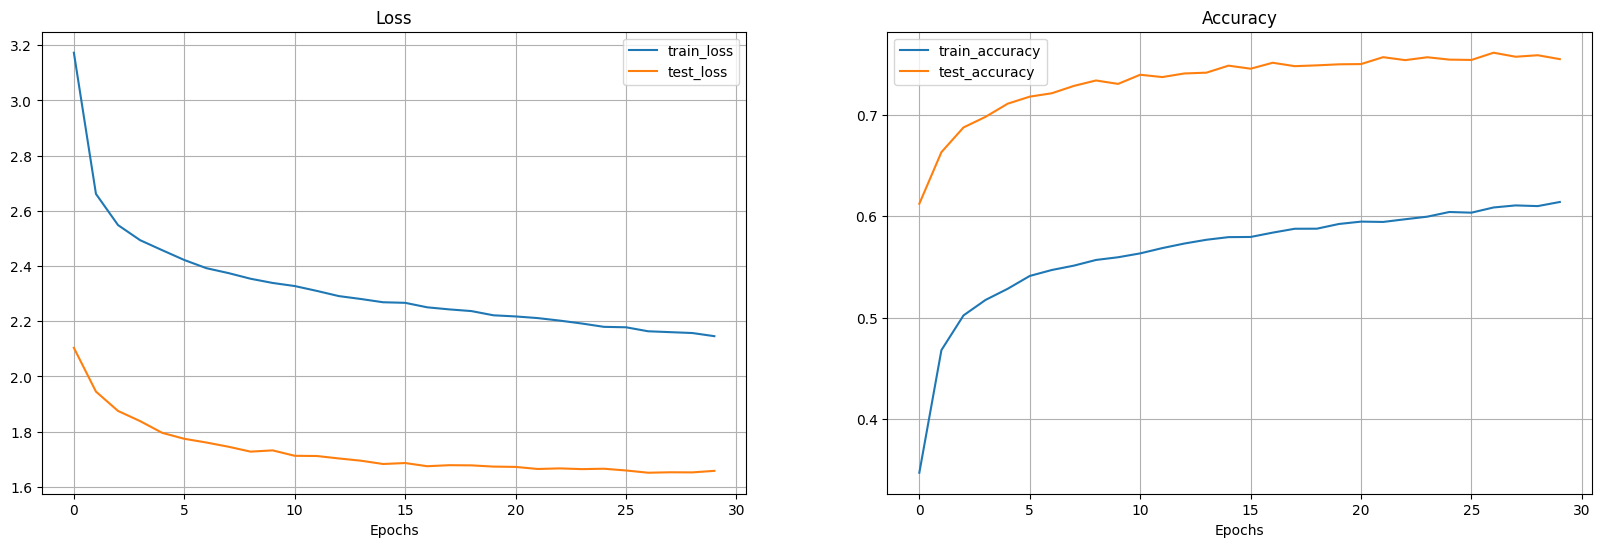

In [ ]:
model_type="vitbase16_v3"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitbase16_3_model_name = model_name + ".pth"
vitbase16_3_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vitbase16_3_model_name}")
print(f"Results path: {vitbase16_3_results_df}")

# Train the model
if ENABLE['train_model']:

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_3_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase16_3_results = train(model=vitbase16_3_model, 
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=None,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                writer=None)

In [14]:
# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitbase16_3_model,
              target_dir=model_dir,
              model_name=vitbase16_3_model_name)
   df_results = pd.DataFrame(vitbase16_3_results)
   df_results.to_csv(os.path.join(model_dir, vitbase16_3_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_v3_lr000100_30epochs.pth


## 4.4 Version 4

In [8]:
# Create a ViT-Base Model
vitbase16_4_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    classif_head_hidden_units=1024,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
vitbase16_4_model.copy_weights(pretrained_vit_weights)

# And freeze the backbone except the classification head params
vitbase16_4_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitbase16_4_model)

# Print sumary
summary(vitbase16_4_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 224, 224]    [64, 101]            --                   Partial
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              False
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    (590,592)            False
│    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
├─Sequential (encoder)                                       [64, 197, 768]       [64, 197, 768]       --                   False
│    └─TransformerEncoderBlock (0)                           [64, 197, 768]       [64, 197

Epoch: 50 | train_loss: 2.0514 | train_acc: 0.6418 | train_time: 2m39s | test_loss: 1.6403 | test_acc: 0.7634 | test_time: 2m2s | lr: 0.0001000000


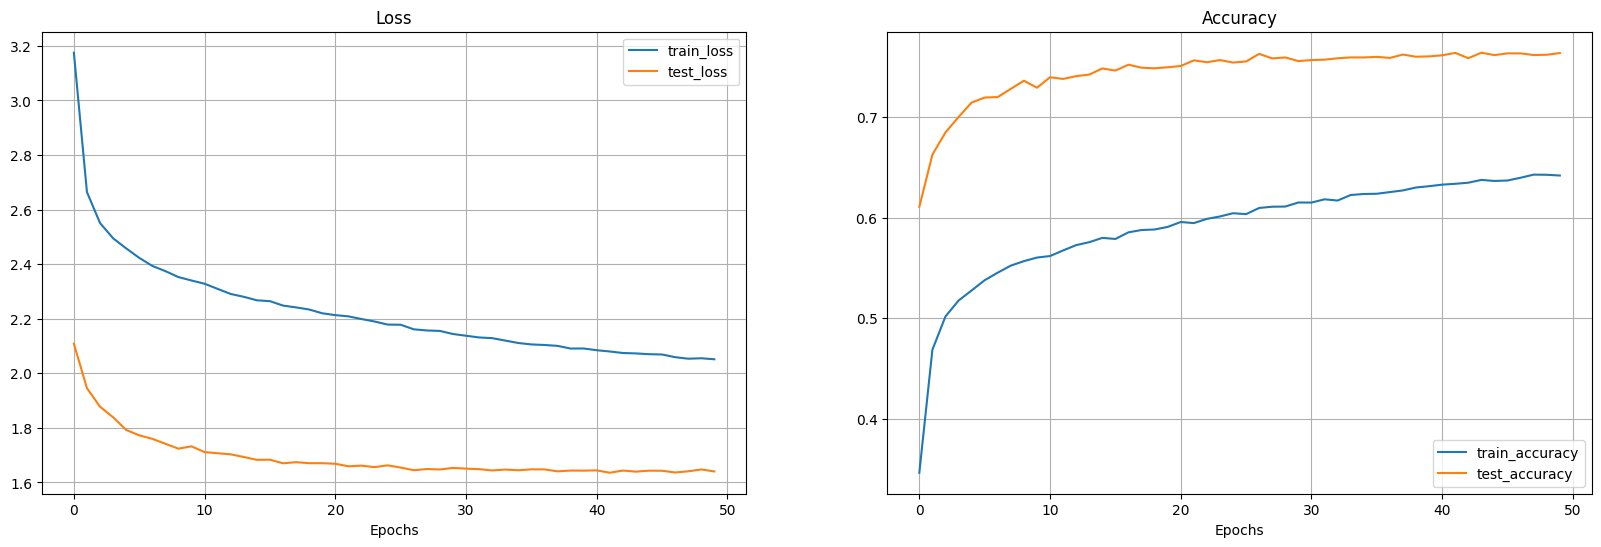

In [ ]:
model_type="vitbase16_v4"
EPOCHS = 50
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitbase16_4_model_name = model_name + ".pth"
vitbase16_4_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vitbase16_4_model_name}")
print(f"Results path: {vitbase16_4_results_df}")

# Train the model
if ENABLE['train_model']:

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_4_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase16_4_results = train(model=vitbase16_4_model, 
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=None,
                                epochs=EPOCHS,
                                device=device,
                                plot_curves=True,
                                amp=True,
                                writer=None)

In [10]:
# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitbase16_4_model,
              target_dir=model_dir,
              model_name=vitbase16_4_model_name)
   df_results = pd.DataFrame(vitbase16_4_results)
   df_results.to_csv(os.path.join(model_dir, vitbase16_4_results_df), index=False)  

[INFO] Saving model to: ..\models\vitbase16_v4_lr000100_50epochs.pth


In [ ]:
# Create a ViT-Large Model
vitbase16_4_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    classif_head_hidden_units=1024,
    num_classes=len(class_names)
)

# Train the model
model_type="vitbase16_v4"
EPOCHS = 50
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitbase16_4_model_name = model_name + ".pth"
vitbase16_4_results_df = model_name + ".csv"

# Load the trained weights
vitbase16_4_model = load_model(model=vitbase16_4_model,
                              model_weights_dir=model_dir,
                              model_weights_name=vitbase16_4_model_name)

# And freeze the backbone except the classification head params
vitbase16_4_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitbase16_4_model)

In [ ]:
# Train the classifier
if ENABLE['train_model']:
    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitbase16_4_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitbase16_4_results_2 = train(model=vitbase16_4_model, 
                                 train_dataloader=train_dataloader_vit,
                                 test_dataloader=train_dataloader_vit,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 scheduler=None,
                                 epochs=EPOCHS,
                                 device=device,
                                 plot_curves=True,
                                 writer=None)

In [ ]:
# Store the 60-epoch version (50 + 10)
model_type="vitbase16_v4"
EPOCHS = 60
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitbase16_4_model_name = model_name + ".pth"
vitbase16_4_results_df = model_name + ".csv"

# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitbase16_4_model,
              target_dir=model_dir,
              model_name=vitbase16_4_model_name)
   df_results_1 = pd.read_csv(os.path.join(model_dir, f"{model_type}_lr{int(LR * 1000000):06d}_15epochs.csv"))
   df_results_2 = pd.DataFrame(vitbase16_4_results_2)
   df_concat = pd.concat([df_results_1, df_results_2], axis=0)
   df_concat.to_csv(os.path.join(model_dir, vitbase16_4_results_df), index=False)  

## 4.5 Version 5

In [ ]:
# Image size
IMG_SIZE = 224

#pretrained_vitl_transforms = torchvision.models.ViT_L_16_Weights.DEFAULT.transforms()
# Manual transforms for the training dataset
manual_transforms_aug_norm_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((242, 242)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test = v2.Compose([    
    v2.Resize((242, 242)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

In [8]:
# Create data loaders
train_dataloader_vitl, test_dataloader_vitl, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

#train_dataloader_vitl, test_dataloader_vitl, class_names

In [5]:
# Create a ViT-Large Model
vitlarge16_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=24,
    emb_dim=1024,
    mlp_size=4096,
    num_heads=16,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Set the pretrained weights of ViT-Large
pretrained_vitl_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
pretrained_vitl = torchvision.models.vit_l_16(weights=pretrained_vitl_weights)
pretrained_vitl.heads = nn.Linear(in_features=1024, out_features=len(class_names))

# Copy weights from torchvision.models.ViT_L_16_Weights.DEFAULT (note: except the header to be trained)
vitlarge16_model.copy_weights(pretrained_vitl_weights)

# And freeze the backbone except the classification head params
vitlarge16_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitlarge16_model)

# Print sumary
summary(vitlarge16_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 224, 224]    [64, 101]            --                   Partial
├─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 1024]      202,752              False
│    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 1024, 14, 14]   (787,456)            False
│    └─Flatten (flatten)                                     [64, 1024, 14, 14]   [64, 1024, 196]      --                   --
│    └─Dropout (emb_dropout)                                 [64, 197, 1024]      [64, 197, 1024]      --                   --
├─Sequential (encoder)                                       [64, 197, 1024]      [64, 197, 1024]      --                   False
│    └─TransformerEncoderBlock (0)                           [64, 197, 1024]      [64, 197

In [6]:
summary(pretrained_vitl,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]    [64, 101]            1,024                True
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]    [64, 1024, 14, 14]   787,456              True
├─Encoder (encoder)                                          [64, 197, 1024]      [64, 197, 1024]      201,728              True
│    └─Dropout (dropout)                                     [64, 197, 1024]      [64, 197, 1024]      --                   --
│    └─Sequential (layers)                                   [64, 197, 1024]      [64, 197, 1024]      --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 1024]      [64, 197, 1024]      12,596,224           True
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 1024]      [64, 197, 10

In [11]:
# Check out that the parameters have been sucessfully copied
#print("Weights of the pretrained model")
#for name, param in pretrained_vitl.named_parameters():
#    print(f"{name}: {param.data.mean()}")

#print("...................")
#print("Weights of the ViTBase model")
#for name, param in vitlarge16_model.named_parameters():
#    print(f"{name}: {param.data.mean()}")

Epoch: 15 | train_loss: 1.8560 | train_acc: 0.7104 | train_time: 16m25s | test_loss: 1.6617 | test_acc: 0.7661 | test_time: 5m6s | lr: 0.0001000000


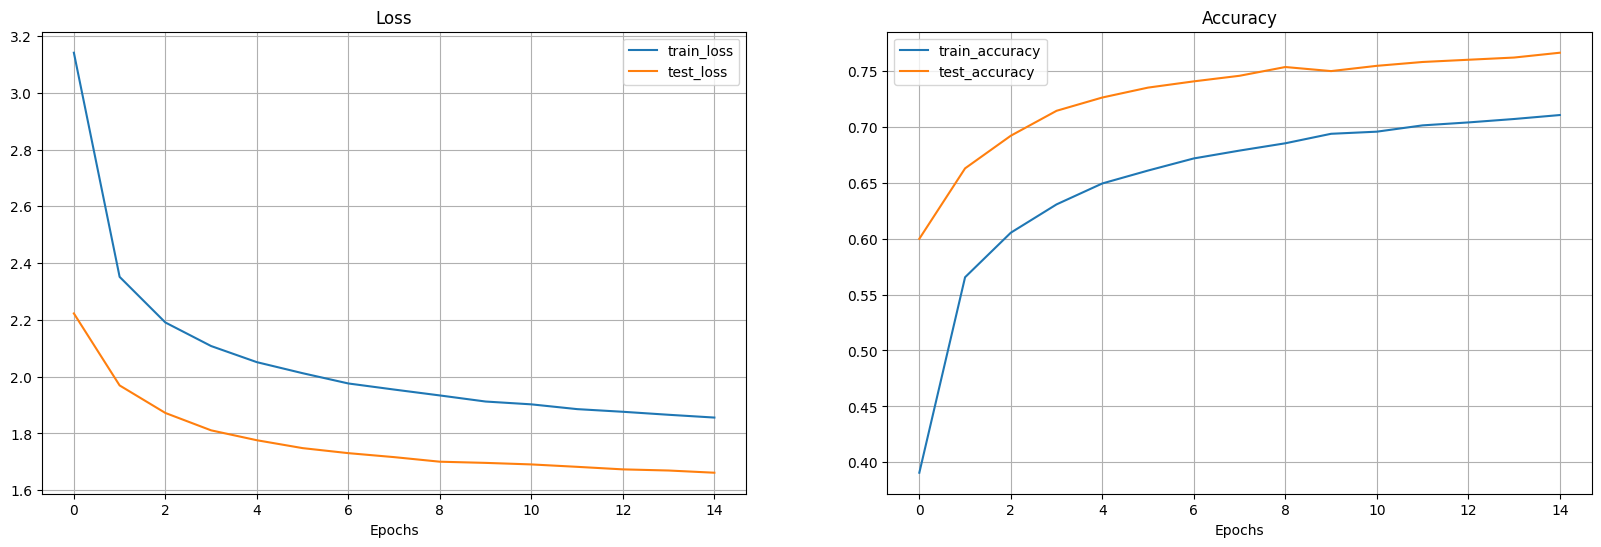

In [8]:
# Train the model
model_type="vitlarge16"
EPOCHS = 15
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitlarge16_model_name = model_name + ".pth"
vitlarge16_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vitlarge16_model_name}")
print(f"Results path: {vitlarge16_results_df}")

# Train the model
if ENABLE['train_model']:

    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set scheduler
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-6)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, min_lr=1e-7)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitlarge16_results = train(model=vitlarge16_model, 
                            train_dataloader=train_dataloader_vitl,
                            test_dataloader=test_dataloader_vitl,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            scheduler=None,
                            epochs=EPOCHS,
                            device=device,
                            plot_curves=True,
                            writer=None)

In [9]:
# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitlarge16_model,
              target_dir=model_dir,
              model_name=vitlarge16_model_name)
   df_results = pd.DataFrame(vitlarge16_results)
   df_results.to_csv(os.path.join(model_dir, vitlarge16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_lr000100_15epochs.pth


Keep training with 15 epochs more.

In [ ]:
# Create a ViT-Large Model
vitlarge16_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=24,
    emb_dim=1024,
    mlp_size=4096,
    num_heads=16,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Train the model
model_type="vitlarge16"
EPOCHS = 15
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitlarge16_model_name = model_name + ".pth"
vitlarge16_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {vitlarge16_model_name}")
print(f"Results path: {vitlarge16_results_df}")

# Load the trained weights
vitlarge16_model = load_model(model=vitlarge16_model,
                              model_weights_dir=model_dir,
                              model_weights_name=vitlarge16_model_name)

# And freeze the backbone except the classification head params
vitlarge16_model.set_params_frozen(except_head=True)

# Compile model
torch.compile(vitlarge16_model)

Model name: vitlarge16_lr000100_15epochs
Model path: vitlarge16_lr000100_15epochs.pth
Results path: vitlarge16_lr000100_15epochs.csv
[INFO] Loading model from: ..\models\vitlarge16_lr000100_15epochs.pth


OptimizedModule(
  (_orig_mod): ViT(
    (embedder): PatchEmbedding(
      (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (flatten): Flatten(start_dim=2, end_dim=3)
      (emb_dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Sequential(
      (0): TransformerEncoderBlock(
        (msa_block): MultiheadSelfAttentionBlock(
          (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (mlp_block): MLPBlock(
          (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=1024, out_features=4096, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=4096, out_features=1024, bias=True)
            (

Epoch: 15 | train_loss: 1.7814 | train_acc: 0.7359 | train_time: 16m9s | test_loss: 1.6431 | test_acc: 0.7732 | test_time: 5m0s | lr: 0.0001000000


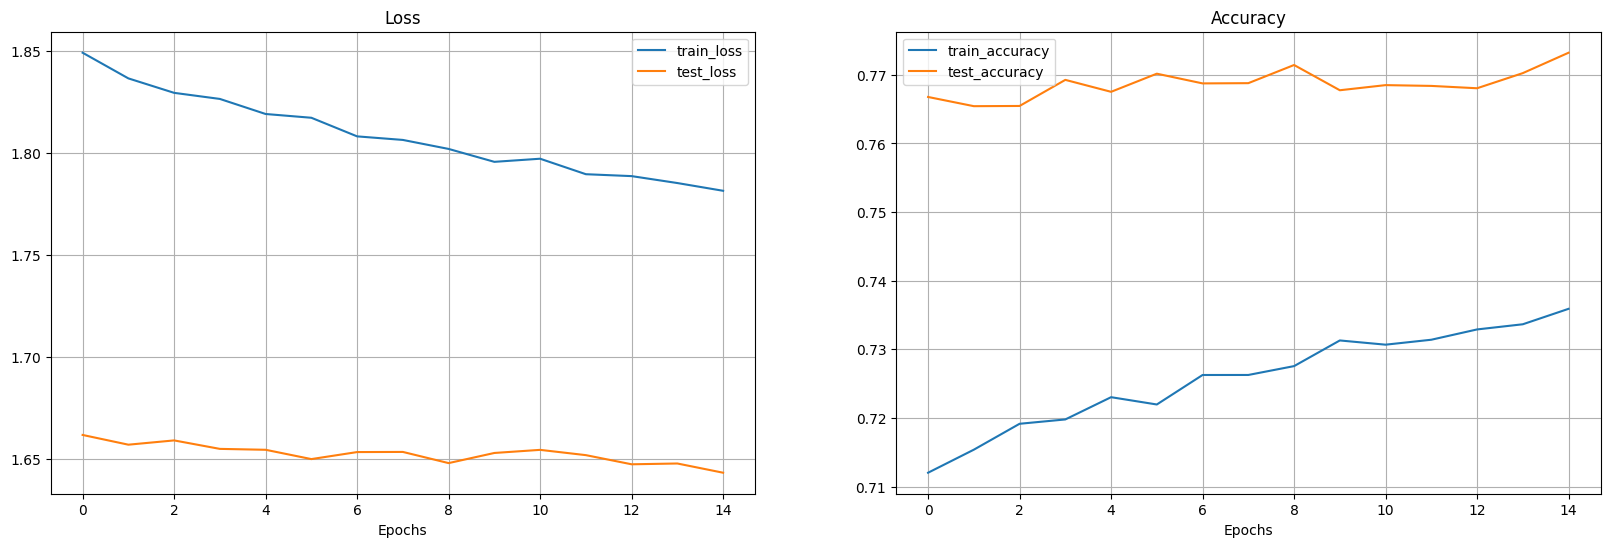

In [9]:
# Train the classifier
if ENABLE['train_model']:
    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitlarge16_results_2 = train(model=vitlarge16_model, 
                                 train_dataloader=train_dataloader_vitl,
                                 test_dataloader=test_dataloader_vitl,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 scheduler=None,
                                 epochs=EPOCHS,
                                 device=device,
                                 plot_curves=True,
                                 writer=None)

In [ ]:
# Store the 30-epoch version (15 + 15)
model_type="vitlarge16"
EPOCHS = 30
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitlarge16_model_name = model_name + ".pth"
vitlarge16_results_df = model_name + ".csv"

# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitlarge16_model,
              target_dir=model_dir,
              model_name=vitlarge16_model_name)
   df_results_1 = pd.read_csv(os.path.join(model_dir, f"{model_type}_lr{int(LR * 1000000):06d}_15epochs.csv"))
   df_results_2 = pd.DataFrame(vitlarge16_results_2)
   df_concat = pd.concat([df_results_1, df_results_2], axis=0)
   df_concat.to_csv(os.path.join(model_dir, vitlarge16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_lr000100_30epochs.pth


Keep training with 10 epochs more.

Epoch: 10 | train_loss: 1.7598 | train_acc: 0.7423 | train_time: 16m12s | test_loss: 1.6505 | test_acc: 0.7689 | test_time: 5m5s | lr: 0.0001000000


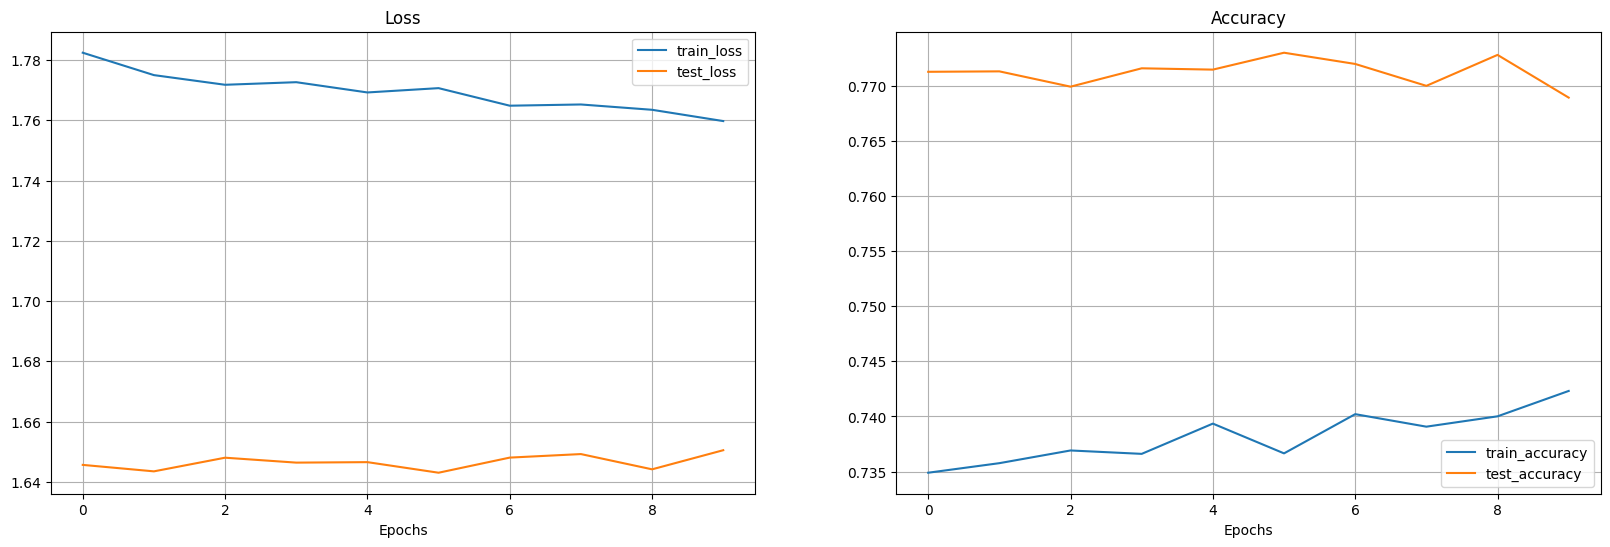

In [12]:
# Train the classifier
EPOCHS = 10
if ENABLE['train_model']:
    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitlarge16_results_3 = train(model=vitlarge16_model, 
                                 train_dataloader=train_dataloader_vitl,
                                 test_dataloader=test_dataloader_vitl,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 scheduler=None,
                                 epochs=EPOCHS,
                                 device=device,
                                 plot_curves=True,
                                 writer=None)

In [ ]:
# Store the 40-epoch version (15 + 15 + 10)
model_type="vitlarge16"
EPOCHS = 40
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitlarge16_model_name = model_name + ".pth"
vitlarge16_results_df = model_name + ".csv"

# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitlarge16_model,
              target_dir=model_dir,
              model_name=vitlarge16_model_name)
   df_results_2 = pd.read_csv(os.path.join(model_dir, f"{model_type}_lr{int(LR * 1000000):06d}_30epochs.csv"))
   df_results_3 = pd.DataFrame(vitlarge16_results_3)
   df_concat = pd.concat([df_results_2, df_results_3], axis=0)
   df_concat.to_csv(os.path.join(model_dir, vitlarge16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_lr000100_40epochs.pth


Keep training with 10 epochs more.

Epoch: 10 | train_loss: 1.7452 | train_acc: 0.7475 | train_time: 16m1s | test_loss: 1.6528 | test_acc: 0.7688 | test_time: 4m59s | lr: 0.0001000000


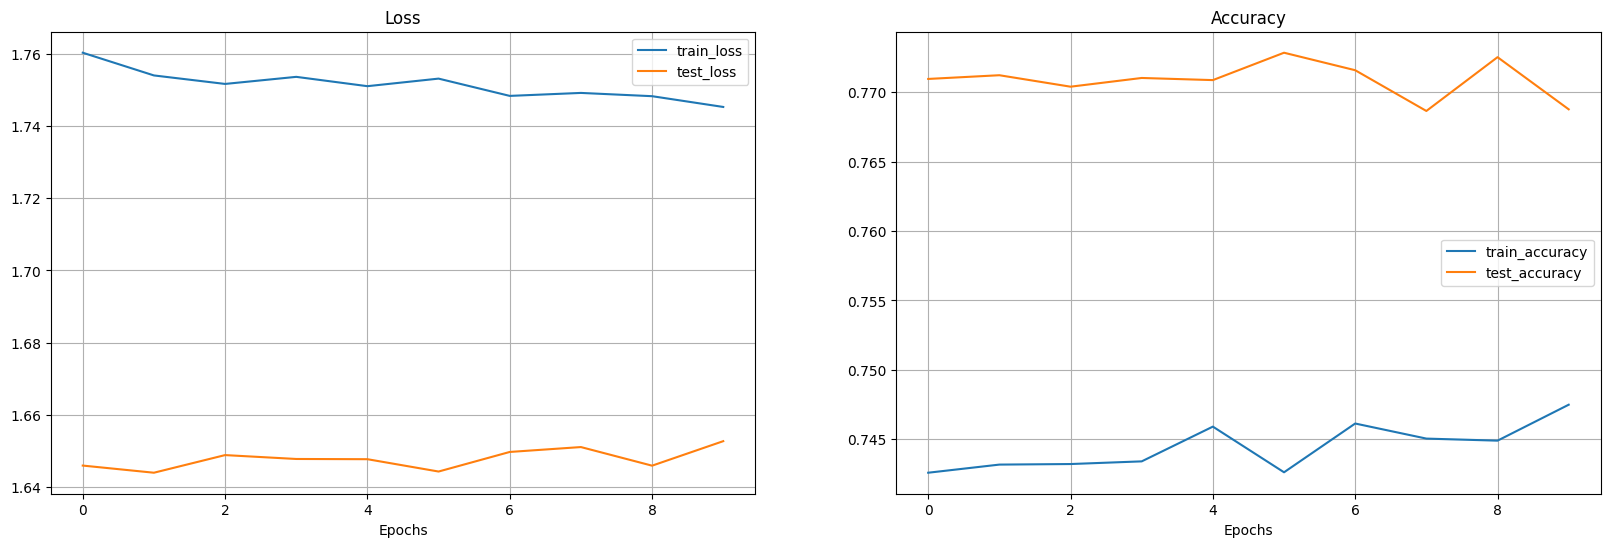

In [ ]:
# Store the 50-epoch version (15 + 15 + 10 + 10)
EPOCHS = 10
if ENABLE['train_model']:
    # Create optimizer
    optimizer = torch.optim.AdamW(params=vitlarge16_model.parameters(),
                                  lr=LR,
                                  betas=(0.9, 0.999),
                                  weight_decay=0.01
    )

    # Create loss function
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    # Set seeds
    set_seeds(SEED)

    # Train the classifier
    vitlarge16_results_4 = train(model=vitlarge16_model, 
                                 train_dataloader=train_dataloader_vitl,
                                 test_dataloader=test_dataloader_vitl,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 scheduler=None,
                                 epochs=EPOCHS,
                                 device=device,
                                 plot_curves=True,
                                 writer=None)

In [15]:
# Train the model
model_type="vitlarge16"
EPOCHS = 50
LR = 0.0001
model_name = f"{model_type}_lr{int(LR * 1000000):06d}_{EPOCHS}epochs"
vitlarge16_model_name = model_name + ".pth"
vitlarge16_results_df = model_name + ".csv"

# Save the Vit-Base model
if ENABLE['save_model']:
   save_model(model=vitlarge16_model,
              target_dir=model_dir,
              model_name=vitlarge16_model_name)
   df_results_3 = pd.read_csv(os.path.join(model_dir, f"{model_type}_lr{int(LR * 1000000):06d}_40epochs.csv"))
   df_results_4 = pd.DataFrame(vitlarge16_results_4)
   df_concat = pd.concat([df_results_3, df_results_4], axis=0)
   df_concat.to_csv(os.path.join(model_dir, vitlarge16_results_df), index=False)  

[INFO] Saving model to: ..\models\vitlarge16_lr000100_50epochs.pth


## 4.3 Training Results

In [ ]:
# Instantiate the model
vitbase = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    embedding_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    embedding_dropout=0.1,
    num_classes=len(class_names)
)
# Load the trained weights
vitbase = load_model(model=vitbase,
                     model_weights_dir=model_dir,
                     model_weights_name=effnetb0_model_name)

# Load the training results
vitbase_results = pd.read_csv(os.path.join(model_dir, effnetb0_results_df))

[INFO] Loading model from: ..\models\vitbase_lr0010_30epochs.pth


In [ ]:
test_acc = vitbase_results['test_acc'].iloc[-1]
test_los = vitbase_results['test_loss'].iloc[-1]
model_size = Path(os.path.join(model_dir, effnetb0_model_name)).stat().st_size // (1024*1024)
print(f"Accuracy on the test set: {test_acc}")
print(f"Loss on the test set: {test_los}")
print(f"Model size: {model_size} MB")

Accuracy on the test set: 0.3046875
Loss on the test set: 1.5383583068847655
Model size: 327 MB
